# Import Libraries

In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [41]:
df=pd.read_csv('/dialogs.txt',sep='\t',names=['question','answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


# Data Preprocessing

## Data Visualization

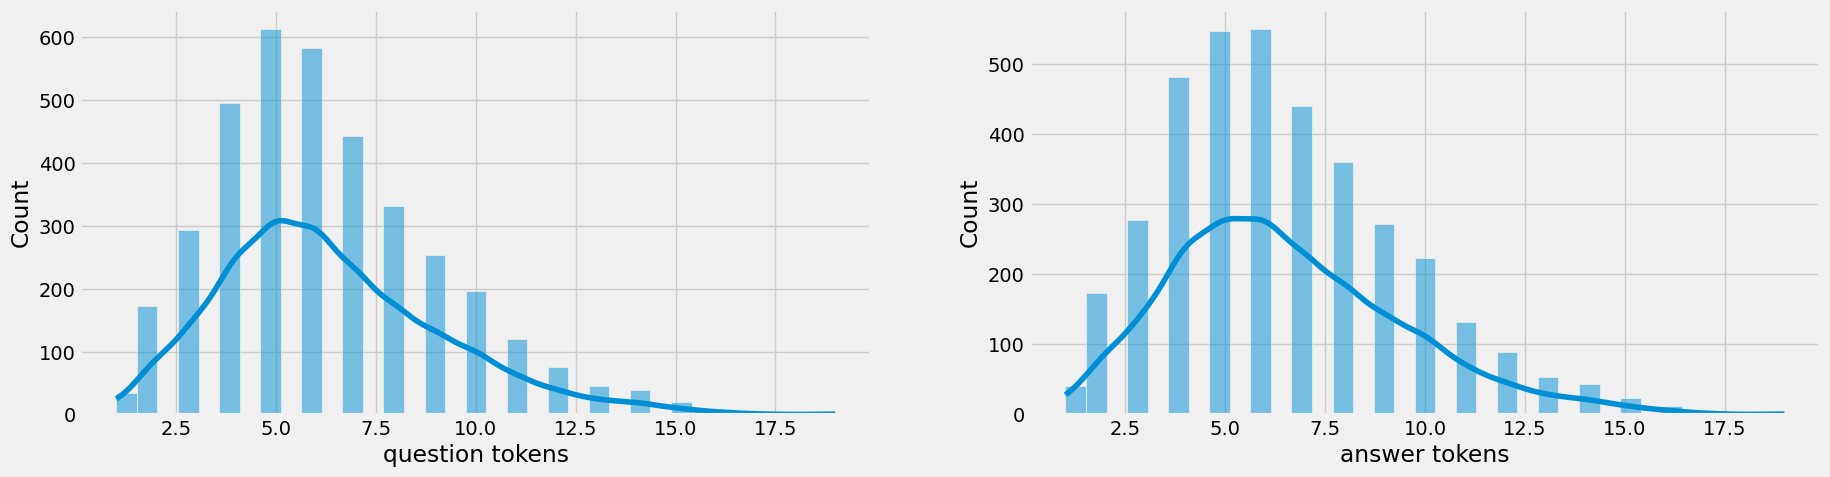

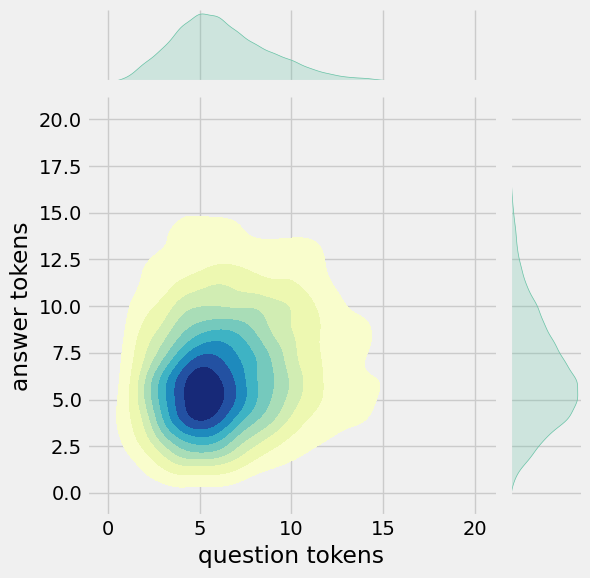

In [42]:


df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['question tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['answer tokens'],data=df,kde=True,ax=ax[1])
sns.jointplot(x='question tokens',y='answer tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

## Text Cleaning

In [43]:


def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


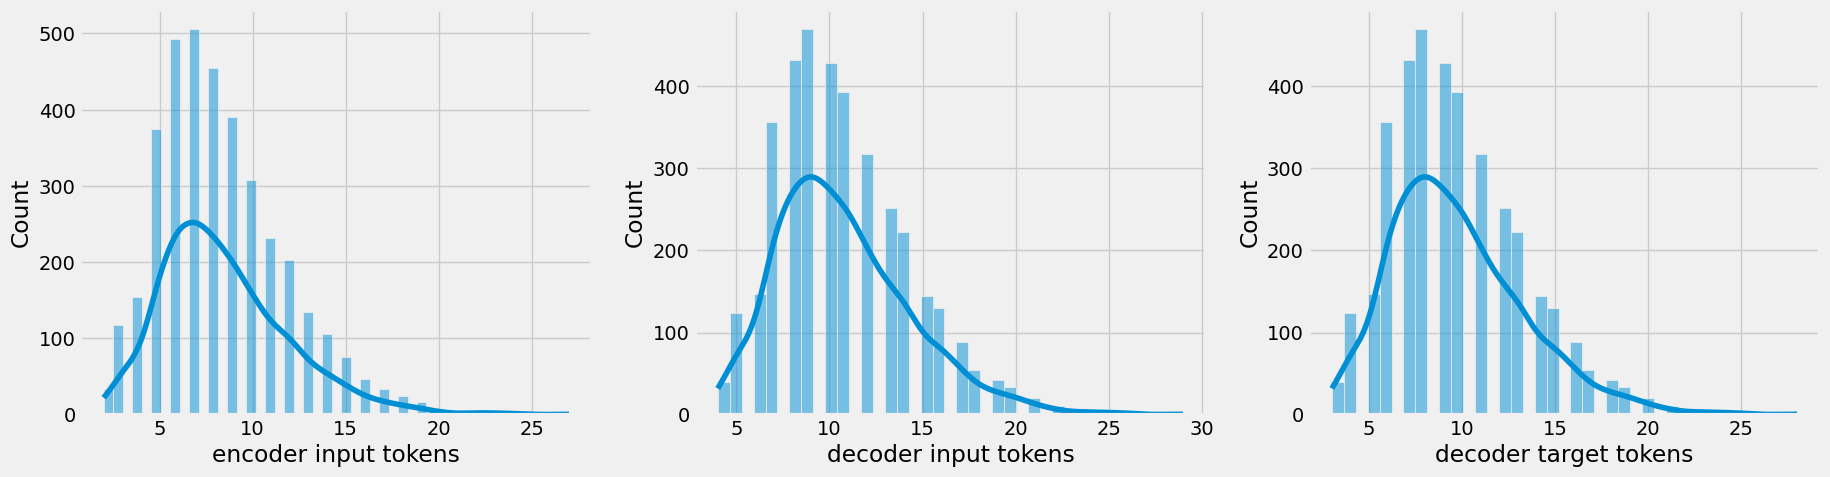

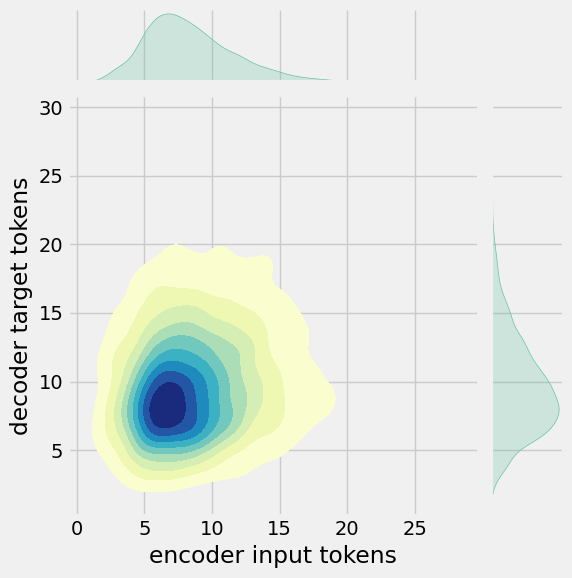

In [44]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=df['encoder input tokens'],data=df,kde=True,ax=ax[0])
sns.histplot(x=df['decoder input tokens'],data=df,kde=True,ax=ax[1])
sns.histplot(x=df['decoder target tokens'],data=df,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=df,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [45]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


## Tokenization

In [46]:


vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [47]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [48]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [49]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


# Build Models

## Build Encoder

In [50]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.11610714, -0.09942063,  0.00490936, ...,  0.09743465,
          0.09618832,  0.07715558],
        [ 0.09589829, -0.0688471 ,  0.10320301, ...,  0.21436046,
         -0.04980572, -0.0830857 ],
        [ 0.13985586, -0.17955069,  0.09398217, ...,  0.17210105,
          0.11495114,  0.00121965],
        ...,
        [ 0.00121833, -0.18887207, -0.074308  , ..., -0.11704228,
         -0.10340071, -0.00085274],
        [-0.14752632,  0.15318248,  0.01253325, ..., -0.02443684,
          0.01670766, -0.09162842],
        [ 0.11449182, -0.09447055,  0.06755497, ..., -0.16131558,
         -0.05366332, -0.05390001]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.27720785, -0.31048456,  0.01325595, ...,  0.14181998,
          0.18560693,  0.13029818],
        [ 0.24213795, -0.1992374 ,  0.2961715 , ...,  0.3248694 ,
         -0.09580294, -0.14484674],
        [ 0.3531795 , -0.61859035,  0.25936234,

Build Encoder##  Build Decoder

In [51]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[3.97573858e-05, 3.66107939e-04, 5.73311700e-05, ...,
         1.08800631e-03, 1.85537705e-04, 5.81951579e-04],
        [1.32621717e-04, 3.98986776e-05, 1.07596090e-04, ...,
         1.06478657e-03, 2.24201285e-04, 1.08435845e-04],
        [1.89448037e-04, 3.86128777e-05, 5.87196031e-04, ...,
         4.99101006e-04, 2.13882522e-05, 4.96686043e-05],
        ...,
        [8.57930991e-06, 3.85519088e-04, 2.10448943e-05, ...,
         5.39106477e-05, 6.36536512e-04, 5.78696700e-03],
        [8.57931354e-06, 3.85519641e-04, 2.10449034e-05, ...,
         5.39106732e-05, 6.36536279e-04, 5.78696700e-03],
        [8.57931354e-06, 3.85519641e-04, 2.10449034e-05, ...,
         5.39106732e-05, 6.36536279e-04, 5.78696700e-03]]], dtype=float32)>

## Build Training Model

In [52]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [53]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[3.97574440e-05, 3.66108114e-04, 5.73311117e-05, ...,
         1.08800584e-03, 1.85537705e-04, 5.81951579e-04],
        [1.32621833e-04, 3.98987140e-05, 1.07596083e-04, ...,
         1.06478622e-03, 2.24201387e-04, 1.08435837e-04],
        [1.89448256e-04, 3.86128850e-05, 5.87196846e-04, ...,
         4.99100541e-04, 2.13882686e-05, 4.96685425e-05],
        ...,
        [8.57930718e-06, 3.85519175e-04, 2.10448889e-05, ...,
         5.39106550e-05, 6.36535871e-04, 5.78696840e-03],
        [8.57930718e-06, 3.85519175e-04, 2.10448889e-05, ...,
         5.39106550e-05, 6.36535871e-04, 5.78696840e-03],
        [8.57930718e-06, 3.85519175e-04, 2.10448889e-05, ...,
         5.39106550e-05, 6.36535871e-04, 5.78696840e-03]],

       [[2.56818457e-04, 1.36577233e-04, 5.67574571e-05, ...,
         1.65331294e-03, 3.04527261e-04, 1.37968105e-04],
        [9.88867134e-04, 2.78508902e-04, 6.01371750e-04, ...,
         2.98852741e-04, 8

##  Train Model

In [54]:
history=model.fit(
    train_data,
    epochs=15,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.2180
Epoch 1: val_loss improved from inf to 1.41380, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 218s 4s/step - loss: 1.6538 - accuracy: 0.2205 - val_loss: 1.4138 - val_accuracy: 0.2724
Epoch 2/15
19/23 [=======================>......] - ETA: 5s - loss: 1.2424 - accuracy: 0.3047

KeyboardInterrupt: 

#  Visualize Metrics

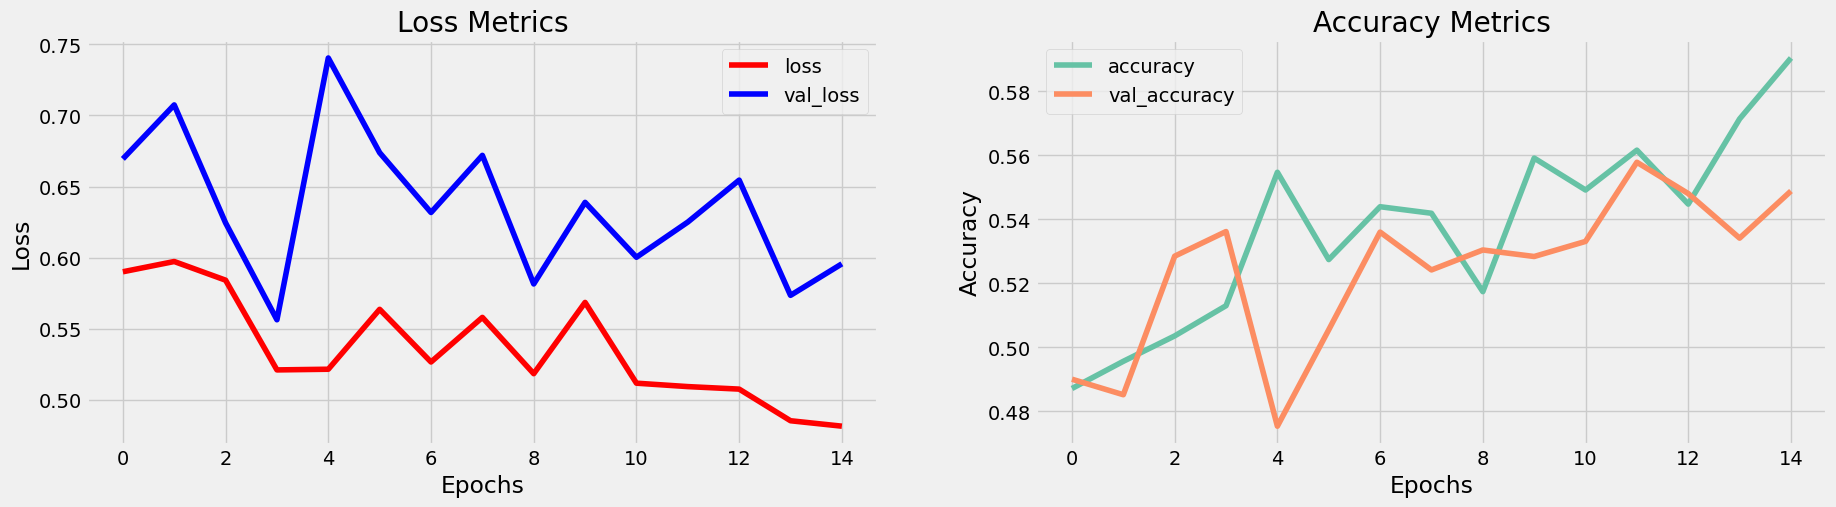

In [ ]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

# Save Model

In [ ]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [ ]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


# Create Inference Model

In [ ]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         625408    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1151232 (4.39 MB)
Trainable params: 1

In [ ]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Time to Chat

In [ ]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [ ]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi


Bot: i don't want to see it. 
You: do yo know me?
Bot: yes, it's the slowest hamburger in town. 
You: what is your name?
Bot: i'm going to get a tan. i'll just buy a ticket now. 
You: you are bot?
Bot: of course. i'll call you. 
You: hi, how are you doing?
Bot: i'm going to see a movie with a movie. 
You: i'm pretty good. thanks for asking.
Bot: no problem. i can't wait till it. 
You: Don't ever be in a hurry
Bot: how much is it? 
You: I'm gonna put some dirt in your eye 
Bot: a good deal. 
You: You're trash 
Bot: you can't have a good nose. 
You: I've read all your research on nano-technology 
Bot: see you go to the movies with a movie. 
You: You want forgiveness? Get religion
Bot: no, i was crossing the street. i was born. 
You: While you're using the bathroom, i'll order some food.
Bot: i'm doing a party. 
You: Wow! that's terrible.
Bot: what do you mean? 
You: We'll be here forever.
Bot: i thought you heard that you're going to be a lot of fun. 
You: I need something that's reliabl